In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EarthPulse Integrations

In this notebook we are going to see an example of how `Pytorch EO` integrates with the rest of [EarthPulse](https://earthpulse.ai/)'s ecosystem: 

- SCAN: our Satellite Collaborative ANnotation Tool, allows us to create, manage and annotate datasets.
- Model Universe: our models repository.

> ⚠ The tools and integrations are under heavy development, so except bugs and breaking changes until we hit an stable version.

## SCAN

SCAN is our tool to create, manage and annotate data. Through a web interface, we explore and download imagery and annotate it with drawing tools. Additionally, we can leverage already trained models to suggest labels instead of having to make them from scratch for every image (AI-assisted labelling).

In [9]:
from pytorch_eo.datasets import SCANDataset
from pytorch_eo.utils.sensors import S2

ds = SCANDataset("eurosat", download=True, batch_size=25, bands=S2.RGB) 

ds.setup()

Login at: https://earthpulse.eu.auth0.com/authorize?response_type=code&scope=openid profile email&client_id=VbvFn0xTckgGKW4Ur96b0LBK3FUvLfKb&redirect_uri=http://spai-mvp.earthpulse.ai/auth/callback?goto=http://192.168.0.14:8003/auth/callback and then enter your code.


Exception: Error: 403 - {'detail': 'Not authenticated'}

In [3]:
ds.df.sample(10)

,image,mask
18,data/eurosat/NwDoY5jR8n9Q49eZnTSp.tif,data/eurosat/NwDoY5jR8n9Q49eZnTSp_mask.tif
11,data/eurosat/C8z8c0TzKJTdJ9zcmEkK.tif,data/eurosat/C8z8c0TzKJTdJ9zcmEkK_mask.tif
2,data/eurosat/3ljtJX9BWqqBgLS9lMDp.tif,data/eurosat/3ljtJX9BWqqBgLS9lMDp_mask.tif
41,data/eurosat/rEitIF1wcCzch39FJQjN.tif,data/eurosat/rEitIF1wcCzch39FJQjN_mask.tif
28,data/eurosat/eO2K0weOE6wCwEy8kJTM.tif,data/eurosat/eO2K0weOE6wCwEy8kJTM_mask.tif
33,data/eurosat/mmN8ABsAhIWxyxVXdDjV.tif,data/eurosat/mmN8ABsAhIWxyxVXdDjV_mask.tif
25,data/eurosat/d2Klq1038m9fDdrWkSUm.tif,data/eurosat/d2Klq1038m9fDdrWkSUm_mask.tif
7,data/eurosat/6zCrqhvuyJmicKhEyZTx.tif,data/eurosat/6zCrqhvuyJmicKhEyZTx_mask.tif
38,data/eurosat/pN8qCd4vChxJfJ30pOFC.tif,data/eurosat/pN8qCd4vChxJfJ30pOFC_mask.tif
31,data/eurosat/jnXYRrBNnaaZGBXRtGHN.tif,data/eurosat/jnXYRrBNnaaZGBXRtGHN_mask.tif


The original version of `EuroSAT` contains 27k S2 images for the task of image classification, each image has one label assigned to it. From this dataset, we built a new version of `EuroSAT` for testing purposes with 50 S2 images extracted randomly from the original dataset and labeled with polygons that can be used for a segmentation task with new labels.


In [4]:
ds.classes

['crops', 'vegetation', 'urban', 'water']

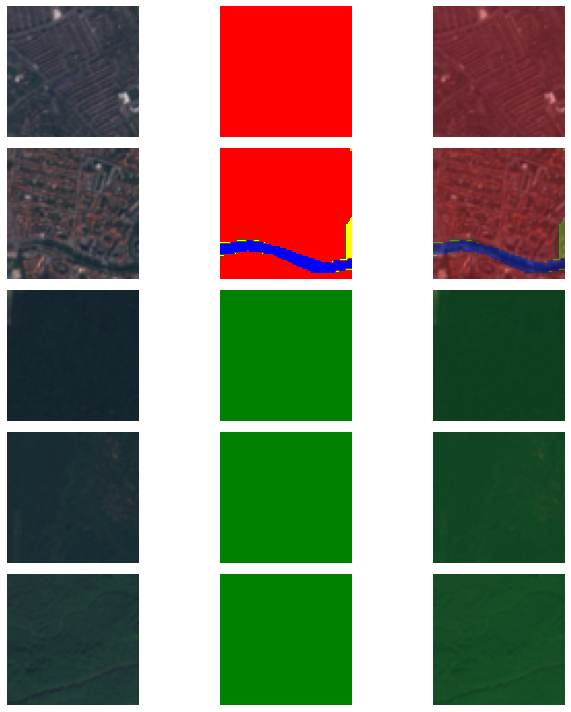

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import torch 
import numpy as np
from pytorch_eo.utils.image import to_uint8
import random

colors = ['yellow', 'green', 'red', 'blue']
cmap = matplotlib.colors.ListedColormap(colors)
boundaries = np.arange(-0.5, len(colors) + 0.5, 1)
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

samples = 5
fig = plt.figure(figsize=(10, samples*2))
th = 4000
for i in range(samples):
    sample = ds.train_ds[random.randint(0, len(ds.train_ds)-1)]
    img, mask = sample['image'], sample['mask']
    img = to_uint8(img, 0, th)
    ax = plt.subplot(samples, 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(samples, 3, 3*i + 2)
    mask = np.argmax(mask, axis=-1)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(samples, 3, 3*i + 3)
    ax.imshow(img)
    ax.imshow(mask, cmap=cmap, norm=norm, alpha=0.3)
    #ax.imshow(mask)
    ax.axis('off')
plt.tight_layout()
plt.show()

Now we can train a model for our task.

In [6]:
from pytorch_eo.tasks.segmentation import ImageSegmentation
import segmentation_models_pytorch as smp
from einops import rearrange
import torch

class Model(torch.nn.Module):

	def __init__(self, in_chans, num_classes, max_value=4000):
		super().__init__()
		self.model = smp.Unet(
			encoder_name='resnet18',
			encoder_weights='imagenet',
			in_channels=in_chans,
			classes=num_classes,
		)
		self.max_value = max_value
		self.sigmoid = torch.nn.Sigmoid()

	def forward(self, x):
		x = rearrange(x, 'b h w c -> b c h w')
		x = x.float() / self.max_value
		x = x.clip(0., 1.)
		y = self.model(x)
		return rearrange(y, 'b c h w -> b h w c')

In [7]:
from pytorch_eo.tasks.segmentation import ImageSegmentation
import albumentations as A

trans = A.Compose([
	A.Resize(64,64)
])

ds = SCANDataset("eurosat", batch_size=32, val_size=0., test_size=0., train_trans=trans, bands=S2.RGB) 

model = Model(in_chans=3, num_classes=4)

task = ImageSegmentation(model)


In [8]:
import pytorch_lightning as pl 

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=50,
	overfit_batches=2
)

trainer.fit(task, ds)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 14.3 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.657    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:473: UserWarning: You requested to overfit but enabled val/test dataloader shuffling. We are turning it off for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:638: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_data

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
def viz_preds(model):
    batch = next(iter(ds.train_dataloader(batch_size=5)))
    imgs, masks = batch['image'], batch['mask']

    model.eval()
    model.cpu()
    with torch.no_grad():
        preds = model(imgs)
    preds = torch.argmax(preds, -1)

    fig = plt.figure(figsize=(10, len(imgs)*4))
    for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):    
        img = to_uint8(img, 0, th)
        ax = plt.subplot(len(imgs), 3, 3*i + 1)
        ax.imshow(img) 
        ax.axis('off')
        ax = plt.subplot(len(imgs), 3, 3*i + 2)
        mask = torch.argmax(mask, axis=-1)
        ax.imshow(mask, cmap=cmap, norm=norm)
        ax.axis('off')
        ax = plt.subplot(len(imgs), 3, 3*i + 3)
        ax.imshow(pred, cmap=cmap, norm=norm)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

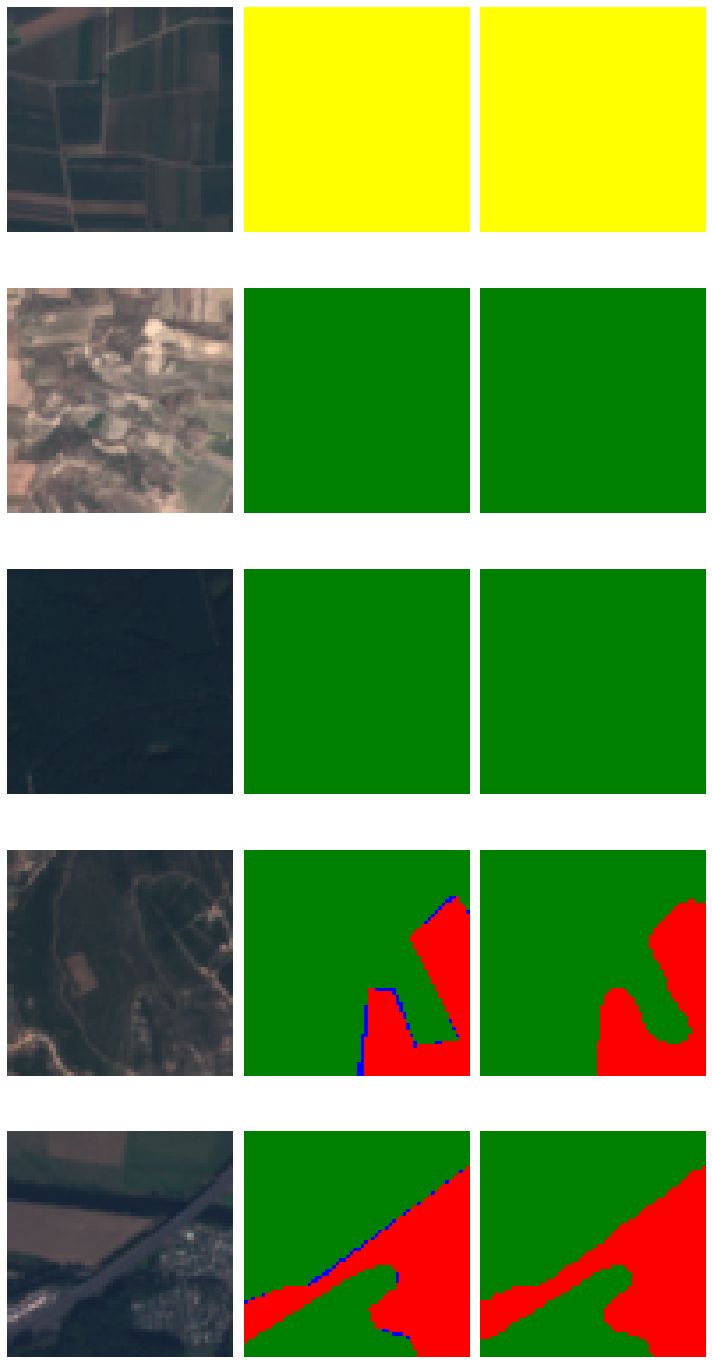

In [10]:
viz_preds(model)

## Models Universe

Once the model is trained, we can upload it to our `Models Universe`. From there, it will be available for inference.

In [21]:
exported_model = torch.nn.Sequential(
	model.cpu(),
	torch.nn.Sigmoid()
)

traced_model = torch.jit.trace(exported_model, torch.randn(5, 64, 64, 3))

traced_model.save('my_model.pth')

/home/juan/miniconda3/lib/python3.9/site-packages/einops/einops.py:179: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  axes_lengths[unknown_axis] = length // known_product


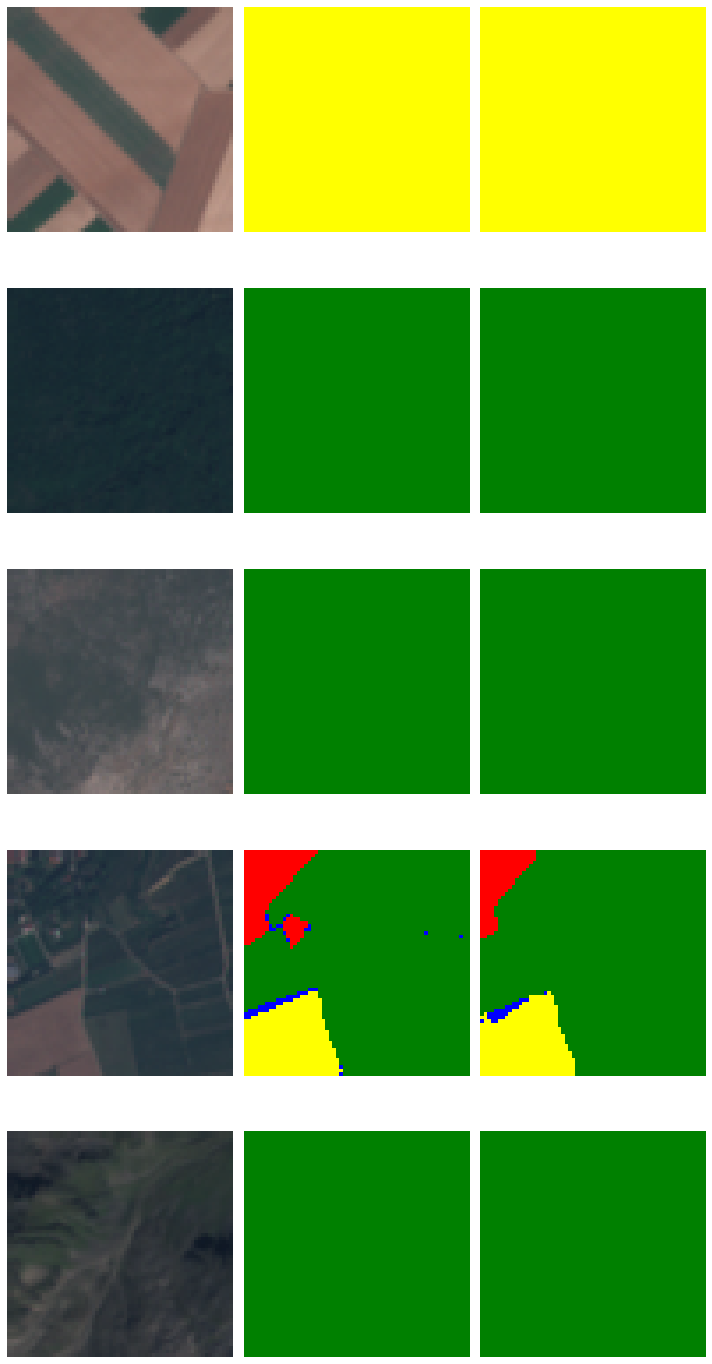

In [22]:
my_model = torch.jit.load('my_model.pth')

viz_preds(my_model)

In [59]:
from pytorch_eo.utils import models_universe

models_universe.upload('my_model.pth', 'eurosat_demo')

{'message': 'successful upload'}

model not found, downloading ... done


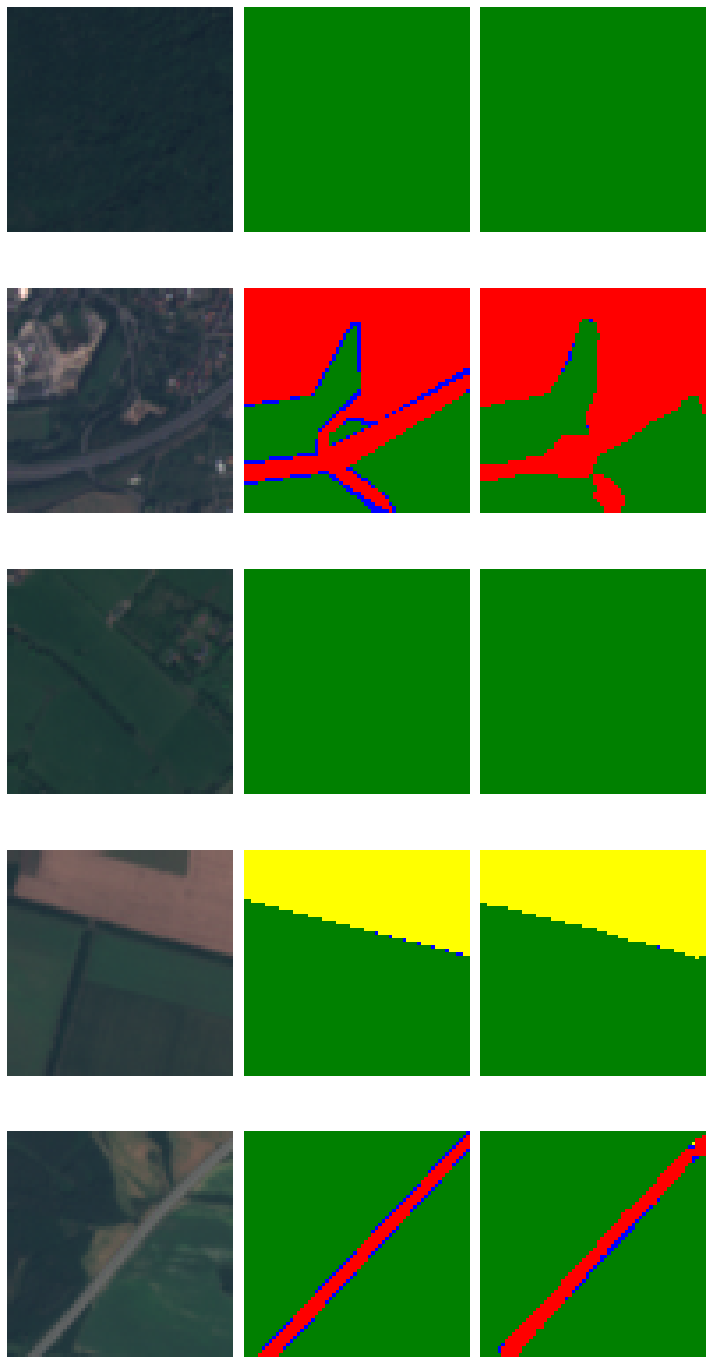

In [62]:
downloaded_model = models_universe.download('eurosat_demo', dest_name='downloaded_model.pth')

viz_preds(downloaded_model)